In [1]:
%config IPCompleter.greedy=True

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import tensorflow as tf
import variational_autoencoder as vae

print("Tensor Flow version {}".format(tf.__version__))

D:\z_outsourced_programs\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Tensor Flow version 1.8.0


In [3]:
#test utils
import weapon_data as weapons

def print_decoded_tensors_as_dict(weapon_data, array_of_tensors):
    genDict = {}
    
    for tensor in array_of_tensors:
        decoded, _ = weapon_data.decode_processed_tensor(tensor)
        
        for key, value in decoded.items():
            if key not in genDict:
                genDict[key] = []
            genDict[key].append(value)
    
    for key, value in genDict.items():
            print(key, "=", value)
            
            
def get_weapon_data():
    return weapons.get_data(2, 13, 0)

In [4]:
network_architecture = \
    dict(n_input=0, #set it in with scope
         n_hidden_1=26,
         n_hidden_2=12,
         n_z=2)  

learning_rate = 0.01
optimizer =  tf.train.RMSPropOptimizer(learning_rate)
transfer_fct = tf.nn.elu
num_epochs = 70
batch_size = 4
epoch_debug_step = 1
    
with tf.Session() as sess:
    train_data, test_data = get_weapon_data()
    network_architecture['n_input'] = train_data.num_features
  
    network = vae.get_new_trained(sess, train_data, network_architecture, optimizer, 
                              transfer_fct, batch_size, num_epochs, epoch_debug_step)


Epoch:0001 - Cost:21.310438381
Epoch:0002 - Cost:17.125075002
Epoch:0003 - Cost:16.700586664
Epoch:0004 - Cost:15.218550915
Epoch:0005 - Cost:15.164929578
Epoch:0006 - Cost:14.306028591
Epoch:0007 - Cost:13.854096450
Epoch:0008 - Cost:12.364231365
Epoch:0009 - Cost:12.893258673
Epoch:0010 - Cost:12.621951621
Epoch:0011 - Cost:12.412936849
Epoch:0012 - Cost:11.314645662
Epoch:0013 - Cost:12.362421576
Epoch:0014 - Cost:11.702547299
Epoch:0015 - Cost:10.785960656
Epoch:0016 - Cost:11.680106741
Epoch:0017 - Cost:10.567544487
Epoch:0018 - Cost:12.030411397
Epoch:0019 - Cost:10.121456672
Epoch:0020 - Cost:10.979067780
Epoch:0021 - Cost:11.130329132
Epoch:0022 - Cost:9.808868318
Epoch:0023 - Cost:10.115104825
Epoch:0024 - Cost:10.430811229
Epoch:0025 - Cost:10.432538941
Epoch:0026 - Cost:9.775308249
Epoch:0027 - Cost:11.428373202
Epoch:0028 - Cost:9.668019798
Epoch:0029 - Cost:10.483662493
Epoch:0030 - Cost:10.093432239
Epoch:0031 - Cost:10.093798525
Epoch:0032 - Cost:9.484885764
Epoch:0033 -

In [5]:
with tf.Session(graph=tf.Graph()) as sess:
    network = vae.get_untrained(sess, network_architecture, optimizer, transfer_fct, batch_size)
    network = vae.restore(network, "trained_vae/model.ckpt")
        
    train_data, test_data = get_weapon_data()
    
    samples = test_data.next_batch(batch_size)
    x_reconstructed = network.encode_and_decode(samples, True)
    print_decoded_tensors_as_dict(test_data, np.concatenate((samples,x_reconstructed), axis=0))


with tf.Session(graph=tf.Graph()) as sess:
    network = vae.get_untrained(sess, network_architecture, optimizer, transfer_fct, batch_size)
    network = vae.restore(network, "trained_vae/model.ckpt")

    train_data, test_data = get_weapon_data()
    
    samples = test_data.next_batch(1)
    x_reconstructed_mean = network.encode_and_decode(samples, False)
    print_decoded_tensors_as_dict(test_data, np.concatenate((samples,[x_reconstructed_mean]), axis=0))

INFO:tensorflow:Restoring parameters from trained_vae/model.ckpt
damages_first = ['53.0', '38.0', '26.5', '80.0', '43.67517207247538', '24.599461054349863', '22.01470231511278', '76.67929826273891']
damages_last = ['38.0', '21.5', '23.0', '80.0', '30.35201548544274', '15.080185988864669', '18.706697513596247', '61.0377021619106']
dmg_distances_first = ['66.0', '10.0', '11.0', '0.0', '43.42812989493006', '10.347734965400107', '15.220484995265268', '-7.8173131216300895']
dmg_distances_last = ['89.0', '47.0', '35.0', '115.0', '64.53591548450206', '29.13717168226191', '35.545889670821595', '113.74377857736096']
firemode_Automatic = ['0.0', '1.0', '1.0', '0.0', '0.3497064809604773', '0.9367879361712201', '1.3357871140224546', '0.21476811528334872']
firemode_Semi-Automatic = ['1.0', '0.0', '0.0', '0.0', '0.4636084039045623', '0.2471033103896942', '-0.1359451942491982', '-0.35039577214164064']
hiprecoildec = ['3.0', '8.0', '6.0', '4.5', '4.2651203035117495', '7.2925611983892455', '6.151896221

In [6]:
with tf.Session(graph=tf.Graph()) as sess:
    network = vae.get_untrained(sess, network_architecture, optimizer, transfer_fct, batch_size)
    network = vae.restore(network, "trained_vae/model.ckpt")
    
    avg_cost_rand = 0.
    avg_cost = 0.

    _, test_data = get_weapon_data()
    num_samples = test_data.num_examples
    total_batch = int(num_samples / batch_size)

    # Loop over all batches
    for i in range(total_batch):
        batch = test_data.next_batch(batch_size)
        cost = network.calculate_loss(batch)        

        rand_sample = np.random.uniform(low=test_data.standardized_min_values, 
                                       high=test_data.standardized_max_values, 
                                       size=(batch_size,network_architecture["n_input"]))
        cost_rand = network.calculate_loss(rand_sample)

        print("Random Cost = " + "{:.2f}".format(cost_rand))

        #compute average loss/cost
        avg_cost_rand += min(cost_rand,1000) / batch_size
        avg_cost += cost / batch_size
    
    print("Random input average cost = " + "{:.2f}".format(avg_cost_rand))   
    print("Test data input average cost = " + "{:.2f}".format(avg_cost))


INFO:tensorflow:Restoring parameters from trained_vae/model.ckpt
Random Cost = 172594773442881912832.00
Random Cost = 2536868269273382912.00
Random Cost = 1554133160143355904.00
Random Cost = 4942331155132186624.00
Random Cost = 551587282944.00
Random input average cost = 1250.00
Test data input average cost = 13.78


INFO:tensorflow:Restoring parameters from trained_vae/model.ckpt


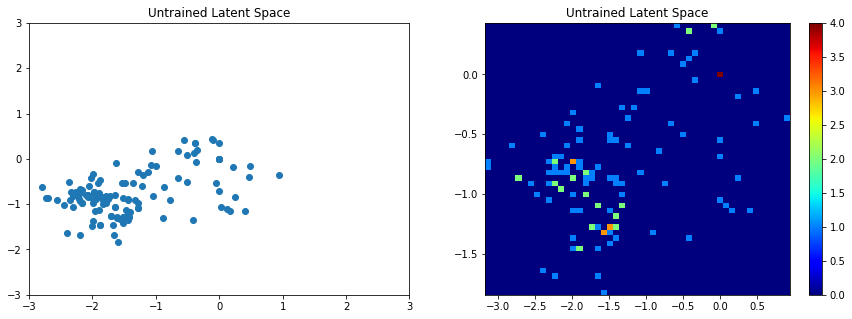

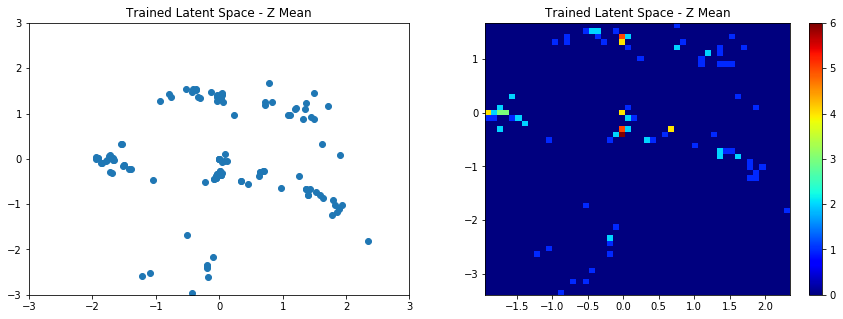

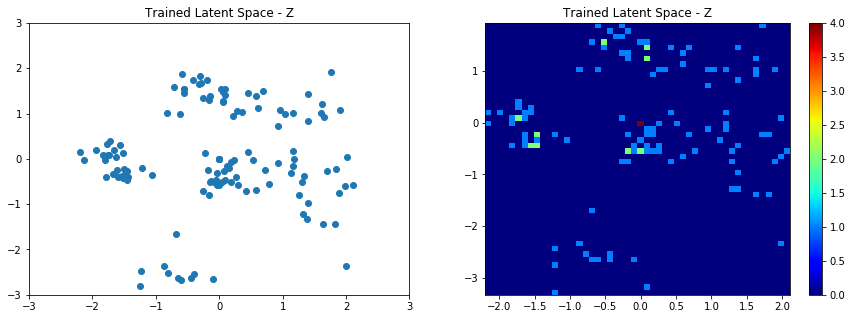

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_z_distribution(vae_model, title, z_mean=True):
    all_z = np.zeros((batch_size,network_architecture['n_z']))
        
    train_data, test_data = get_weapon_data()
    total_batch = int(train_data.num_examples / batch_size) 

    # Loop over all batches
    for i in range(total_batch):
        batch = train_data.next_batch(batch_size)
        z_dist = vae_model.calculate_z(batch)
        if z_mean:
            z_dist = vae_model.calculate_z_mean(batch)
        all_z = np.vstack((all_z, z_dist))

    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.scatter(all_z[:,0], all_z[:,1])
    plt.xlim(-3,3)
    plt.ylim(-3,3)
    plt.title(title)
    plt.subplot(1,2,2)
    plt.hist2d(all_z[:,0], all_z[:,1], (50, 50), cmap=plt.cm.jet)
    plt.colorbar()
    plt.title(title)
    
with tf.Session(graph=tf.Graph()) as sess:
    network = vae.get_untrained(sess, network_architecture, optimizer, transfer_fct, batch_size)
    show_z_distribution(network, "Untrained Latent Space", z_mean=True)
    network = vae.restore(network, "trained_vae/model.ckpt")
    show_z_distribution(network, "Trained Latent Space - Z Mean", z_mean=True)    
    show_z_distribution(network, "Trained Latent Space - Z", z_mean=False)

In [8]:
# Testing single input in latent space
with tf.Session(graph=tf.Graph()) as sess:
    network = vae.get_untrained(sess, network_architecture, optimizer, transfer_fct, batch_size)
    network = vae.restore(network, "trained_vae/model.ckpt")
    
    generated = []

    random_val = np.random.normal(size=(1,network_architecture["n_z"]))
    x_test = network.decode_from_latent_space(random_val, False)
    #[generated.append(x) for x in x_test]
    generated.append(x_test)  
    
    train_data, test_data = get_weapon_data()
    print_decoded_tensors_as_dict(train_data, generated)

INFO:tensorflow:Restoring parameters from trained_vae/model.ckpt
damages_first = ['27.263936701672474']
damages_last = ['19.113330013605285']
dmg_distances_first = ['14.739550173298152']
dmg_distances_last = ['36.63805317307938']
firemode_Automatic = ['0.9092576021406127']
firemode_Semi-Automatic = ['0.17921089007188606']
hiprecoildec = ['7.132951380654595']
hiprecoilright = ['0.22992708153303565']
hiprecoilup = ['0.31396454195542844']
hipstandbasespreaddec = ['3.700355843120847']
initialspeed = ['506.43458571093015']
magsize = ['21.71457933253968']
reloadempty = ['3.503138569500356']
rof = ['551.4279232021785']
shotspershell = ['1.2410389309340037']
type_Shotgun = ['-0.011393620058910522']
type_Pistol = ['0.1984958939907944']
type_Rifle = ['0.3039079137989705']
type_Submachine Gun = ['0.4490758110706213']
type_Sniper Rifle = ['0.011702724712392254']


In [9]:
# Testing batch input in latent space
with tf.Session(graph=tf.Graph()) as sess:
    network = vae.get_untrained(sess, network_architecture, optimizer, transfer_fct, batch_size)
    network = vae.restore(network, "trained_vae/model.ckpt")
    
    generated = []

    random_val = np.random.normal(size=(batch_size,network_architecture["n_z"]))
    x_test = network.decode_from_latent_space(random_val, True)
    [generated.append(x) for x in x_test]
    
    
    random_val = np.random.normal(size=(batch_size,network_architecture["n_z"]))
    x_test = network.decode_from_latent_space(random_val, True)
    [generated.append(x) for x in x_test]
    
    train_data, test_data = get_weapon_data()
    print_decoded_tensors_as_dict(train_data, generated)

INFO:tensorflow:Restoring parameters from trained_vae/model.ckpt
damages_first = ['26.934589866429828', '50.74991400796283', '56.68314993335576', '47.364527300825756', '94.08812667709995', '85.95081210854792', '26.427037084402166', '75.34829718048795']
damages_last = ['20.02087906372541', '36.09868602549555', '35.83849387512017', '34.66385853358094', '72.03588087286928', '54.46929568287071', '19.433899617149024', '46.42682580662675']
dmg_distances_first = ['13.787511730855954', '39.433043158512966', '32.72417548377115', '40.363266288667695', '5.133182335506293', '18.00785361820897', '10.227150504246925', '23.89585555543802']
dmg_distances_last = ['39.14907748659786', '75.87120766946724', '70.16417545980735', '74.70921566516076', '126.34642538308167', '91.73748137066788', '35.91612818175737', '80.94483085846943']
firemode_Automatic = ['1.09585013522762', '0.20205114108915015', '0.1676163762926878', '0.23203490049695968', '-0.006935273774014095', '0.04545878210321408', '1.032173207720352